In [1]:
"""
Python implementation of the Zeng & Beljaars 2005 diurnal SST scheme.
Partly merged with https://github.com/reykboerner/diusst

Test with buoy and AROME Arctic data

Author: Malte Müller (maltem@met.no)
Date: 01 June 2023

References:
[1] Zeng and Beljaars (2005), https://doi.org/10.1029/2005GL023030
"""

__author__ = "Malte Mueller"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Atmospheric Data

In [3]:
class AtmosData: 
    """ 
    Define input data
    Definition of variables according to the extraction script
    lnet  :: longwave net (pos. down)
    fheat :: turbulent heat fluxes (pos. down)
    wspeed :: wind speed in m/s"""
    def  __init__(self):
        self.time = None
        self.snet = None
        self.lnet = None
        self.wspeed = None
        self.fheat = None

### Zeng & Beljaars Model

In [4]:
class ZBmodel:

    def __init__(self, takaya10=True, reflect=False, 
        T_f = 300,                      # foundation temperature (K)
        d = 3,                          # warm layer depth (m)
        nu = 0.3,                       # profile shape parameter
        k = 0.4,                        # von Karman constant
        g = 9.81,                       # gravity (m/s²)
        k_w = 1e-7,                     # molecular diffusion coeff. (m²/s)
        a_w = 2.9e-4,                   # thermal expansion coeff. of seawater (1/K)
        nu_w = 9e-7,                    # kinematic viscosity of seawater (m²/s)
        rho_w = 1027,                   # density of seawater (kg/m³)        
        rho_a = 1.1,                    # density of air (kg/m³)        
        cp_w = 3850,                    # specific heat capacity of seawater (J/(kg K))
        cp_a = 1005,                    # specific heat capacity of air (J/(kg K))
        n_w = 1.34,                     # refractive index of seawater
        n_a = 1.0,                      # refractive index of air
        C_s = 1.3e-3,                   # Stanton number
        C_l = 1.5e-3,                   # Dalton number
        L_evap = 2.5e6,                 # Latent heat of vaporization (J/kg)
        sb_const = 5.67e-8,             # Stefan-Boltzmann constant (W/(m K²)²)
        gas_const = 461.51,             # gas constant of water vapor (J/(kg K))
        rad_a = [0.28, 0.27, 0.45],     # coefficients of radiation absorption scheme
        rad_b = [71.5, 2.8, 0.07],      # exponents of radiation absorption scheme (1/m)
        z_wind = 10,                    # wind speed measurement height above sea level (m)
        z_rough = None):                # roughness height of sea surface (m)

        self.T_f = T_f
        self.d = d
        self.nu = nu
        self.k = k
        self.g = g
        self.k_w = k_w
        self.a_w = a_w
        self.nu_w = nu_w
        self.rho_w = rho_w
        self.rho_a = rho_a
        self.cp_w = cp_w
        self.cp_a = cp_a
        self.n_w = n_w
        self.n_a = n_a
        self.C_s = C_s
        self.C_l = C_l
        self.L_evap = L_evap
        self.sb_const = sb_const
        self.gas_const = gas_const
        self.rad_a = rad_a
        self.rad_b = rad_b
        self.takaya10 = takaya10        # Refinements of Takaya et al. (2010)
        self.reflect = reflect          # surface reflection of incident radiation
        self.z_wind = z_wind
        self.z_rough = z_rough


    def Fd(self, data, tidx):
        """ Faktor F_d defined in Eq.(10) (without g*rho) in ZB2005 """
        return data.lnet[tidx]+data.fheat[tidx] + data.snet[tidx] - 0.36*data.snet[tidx]
        
    def faktor1(self, data, tidx):
        """ 
        Faktor 1 in Eq. (11) in ZB2005
        Q+Rs-R(-d) # While we assume that R(-d)=0.36*R at a depth of 3m # ASSUMPTION
        """
        numerator   = self.Fd(data, tidx) 
        denominator = self.d * self.rho_w * self.cp_w * self.nu/(self.nu + 1)
        return numerator / denominator

    def friction_vel(self, data, tidx, C_drag=0.0015):
    
        # Friction Velocity
        # -----------------
        #Calculates the friction velocity in the water, given wind speed u at height z_wind above the surface.
        #z0 is the roughness height of the surface (e.g., average wave height).
        #Source: https://www.calculatoratoz.com/en/eniction-veloceny-for-known-wind-speed-at-height-above-surface-calculator/calc-23770
        #and https://en.wikipedia.org/wiki/Shear_velocity
        #and Takaya et al. (2010)  
        wind_stress = self.rho_a*C_drag*data.wspeed[tidx]**2
        friction_vel = np.sqrt(wind_stress/self.rho_w)
        return friction_vel
        #friction_vel = self.k*data.wspeed[tidx]/np.log(self.z_wind/z0)*np.sqrt(self.rho_a/self.rho_w)
        
    def stability_function(self, x):
        """Eq. (9) of Zeng and Beljaars 2005 [1]"""
        if x >= 0:
            if self.takaya10:
                return 1 + (5*x + 4*x**2)/(1 + 3*x + 0.25*x**2)
            else:
                return 1 + 5*x
        else:
            return (1 - 16*x)**(-0.5)

    def L_MO(self, data, tidx):
        """Monin-Obukhov length, eq. (10) of Zeng and Beljaars 2005 [1]"""
        u_fric = self.friction_vel(data, tidx)
        
        return (self.rho_w*self.cp_w*u_fric**3)/(self.k*self.rho_w*self.g*self.Fd(data,tidx))

    def faktor2(self, data, tidx):
        """Faktor 2 in Eq. (11) in ZB2005"""
        numerator = (self.nu + 1) * self.k * self.friction_vel(data,tidx)
        denominator = self.d * self.stability_function(self.d/self.L_MO(data,tidx))
        #
        return numerator / denominator
    
    def fracS(self,data,tidx,delta):
        """fraction solar radiation absorption in the sublayer Eq(5) in ZB2005"""
        return 0.065 + 11*delta - 6.6e-5/delta*(1 - np.exp(-delta/(8e-4)))

        
#    def layerthk(self,data,tidx,delta):
#        """thickness of the skin layer Eq(6) in ZB2005"""
#        """with old layerthk delta"""
#        u_fric = self.friction_vel(data, tidx)
#        fak1 = (-16*self.g*self.a_w*self.nu_w**3) / (u_fric**4*self.k_w*self.rho_w*self.cp_w)    
#        fak2 = data.lnet[tidx]+data.fheat[tidx] + self.fracS(data,tidx,delta) * data.snet[tidx]
#        print (fak1,fak2)
#        return min(0.01,6* (1+ (fak1*fak2)**(0.75))**(-1/3)) 

    def layerthk(self, data, tidx, delta):
        """Eq. (6) of Zeng and Beljaars 2005 [1]
        with correction according to Fairall et al. 1996 eqs. (12) and (14) [2]
        and modification according to the COARE3.6 algorithm [3]"""
        
        heatflux = data.lnet[tidx]+data.fheat[tidx] + self.fracS(data,tidx,delta) * data.snet[tidx]       
                
        u_fric = self.friction_vel(data, tidx)
        
        factor = - (16*self.g*self.a_w*self.nu_w**3)/(u_fric**4*self.k_w**2*self.rho_w*self.cp_w)
        #print(factor)
        delta_new = 6*(1 + (max(0, factor*heatflux)**(3/4)))**(-1/3)*self.nu_w/u_fric
        return min(0.01, delta_new)
        #return 0.01
    
    
    def skinTfactor(self,data,tidx,delta):
        """for the skin Temperature Eq(4) in ZB2005"""
        fak = delta / (self.rho_w * self.cp_w *self.k_w)
        return fak * (data.lnet[tidx]+data.fheat[tidx] + self.fracS(data,tidx,delta) * data.snet[tidx])
    
    def simulate_ZB(self, data, dTemp0,delta0):        
        """ (1) Simple implicit time scheme for dTemp Eq.(11) in ZB2005"""
        
        dTemp = np.zeros(len(data.time))
        dTs   = np.zeros(len(data.time))
        delta = np.zeros(len(data.time))
        dTemp[0] = dTemp0   
        delta[0] = delta0
        dT=data.time[1]-data.time[0]       
        for tidx in range(1,len(data.time)):
            
            a=self.faktor1(data,tidx)
            b=-self.faktor2(data,tidx)
            #print(a*dT,b*dT)
            #print(a,b)
            #dTemp[tidx] = (dT * a + dTemp[tidx-1]) / (1 - dT * b)
            dTemp[tidx] = dTemp[tidx-1] + ( b*dTemp[tidx-1])*dT
            
            delta[tidx] = self.layerthk(data,tidx,delta[tidx-1]) # update layer thickness          
            dTs[tidx] = self.skinTfactor(data,tidx,delta[tidx])
            
        return dTemp,dTs,delta

### Run model with synthetic data

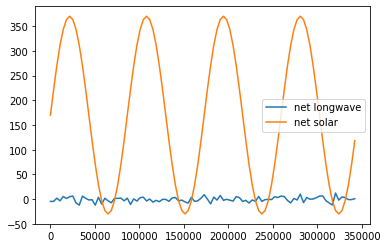

In [5]:
data=AtmosData()

#Generaty a dummy field
data.time = np.arange(0,4*24*60*60,3600)
data.snet = 200*np.sin ( 2*np.pi/(24*3600) *data.time)+170
data.lnet = np.random.randn(len(data.time))*5
data.wspeed = 0.*data.lnet +1
data.fheat = 0.*data.lnet

plt.plot(data.time,data.lnet,label='net longwave')
plt.plot(data.time,data.snet,label='net solar')
plt.legend()

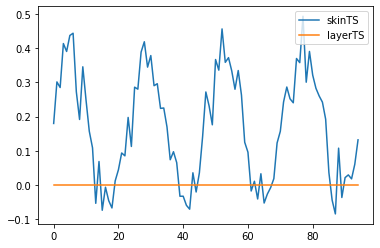

In [6]:
SSTmodel=ZBmodel()
dTemp, dTs, delta = SSTmodel.simulate_ZB(data,0,0.01)
plt.plot(dTs[1:100],label='skinTS')
plt.plot(dTemp[1:100],label='layerTS')
plt.legend()
#plt.plot(data.snet/300)
#plt.plot(delta)

### Run with buoy and AROME Arctic data

In [7]:
import pickle
with open(f'data/AAforce.pickle', 'rb') as file: # AROME Arctic forcing along trajectory
    AAforce = pickle.load(file)
with open(f'data/dsst.pickle', 'rb') as file: # Drifter SST
    dsst = pickle.load(file)
with open(f'data/gsst.pickle', 'rb') as file: # GOTM SST
    gsst =  pickle.load(file)  

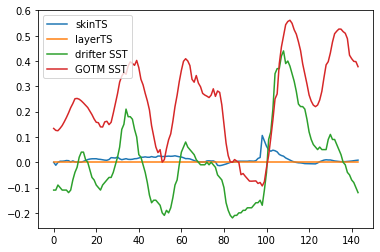

In [8]:
SSTmodel=ZBmodel()
dTemp, dTs, delta = SSTmodel.simulate_ZB(AAforce,0,0.01)
plt.plot(dTs[:],label='skinTS')
plt.plot(dTemp[:],label='layerTS')
plt.plot(dsst-9,label='drifter SST')
plt.plot(gsst-9,label='GOTM SST')
plt.legend()